In [2]:
# Use only the provided packages
import sys
import math
import csv
import pandas
import os
import random
import numpy as np
from collections import Counter
from dataclasses import dataclass

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

mpl.lines.width = 2
mpl.axes.labelsize = 14

In [3]:
class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y

In [4]:
from ast import YieldFrom
class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        prob_arr = np.bincount(y)
        prob_0 = prob_arr[0] / len(y)
        prob_1 = prob_arr[1] / len(y)
        prob_dict = {0: prob_0, 1: prob_1}
        self.probabilities_ = prob_dict

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)
        n, d = X.shape
        y = np.random.choice(list(self.probabilities_.keys()), n, list(self.probabilities_.values()))
        return y


In [5]:
def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,20))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend()

    plt.savefig ('histograms.pdf')

def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

    return data, bins, align, labels

In [6]:
def error(clf, X, y, ntrials=1, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    train_error_list = []
    test_error_list = []
    f1_score_list = []

    split1 = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)
    # For each split, find the train error, test error and f1 score
    for train_index, test_index in split1.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        train_error = 1 - metrics.accuracy_score(y_train, y_pred_train, normalize=True)
        test_error = 1 - metrics.accuracy_score(y_test, y_pred_test, normalize=True)
        f1_score = metrics.f1_score(y_test, y_pred_test, average='micro')
        train_error_list.append(train_error)
        test_error_list.append(test_error)
        f1_score_list.append(f1_score)

    train_error = sum(train_error_list) / len(train_error_list)
    test_error = sum(test_error_list) / len(test_error_list)
    f1_score = sum(f1_score_list) / len(f1_score_list)

    return train_error, test_error, f1_score

In [8]:
# Load the Mushroom dataset

@dataclass
class Dataset:
    """Class for the dataset."""
    X: np.array
    y: np.array
    Xnames: list
    yname: str

def load_data(data_file='mushroom.txt'):
    """Load data and map strings to numbers."""
    data = pandas.read_csv(data_file).to_numpy()
    n = data.shape[0]
    d = data.shape[1] - 1
    # Map strings to numbers
    X = np.zeros((n, d))
    for i in range(d):
        mapping = {name: j for j, name in enumerate(sorted(set(data[:, i+1])))}
        for j in range(n):
            X[j, i] = mapping[data[j, i+1]]
    mapping = {'EDIBLE': 1, 'POISONOUS': 0}
    y = np.zeros(n, dtype=np.int32)
    for j in range(n):
        y[j] = mapping[data[j, 0]]
    #0 'cap-shape', 
    #1 'cap-surface', 
    #2 'cap-color', 
    #3 'bruises', 
    #4 'odor',      
    #5 'gill-attachment', 
    #6 'gill-spacing', 
    #7 'gill-size', 
    #8 'gill-color',
    #9 'stalk-shape', 
    #10 'stalk-root', 
    #11 'stalk-surface-above-ring', 
    #12 'stalk-surface-below-ring',
    #13 'stalk-color-above-ring',
    #14 'stalk-color-below-ring',
    #15 'veil-type',
    #16 'veil-color',
    #17 'ring-number',
    #18 'ring-type',
    #19 'spore-print-color',
    #20 'population',
    #21 'habitat',        
    Xnames = [
        'cap-shape', 
        'cap-surface', 
        'cap-color', 
        'bruises', 
        'odor',
        'gill-attachment', 
        'gill-spacing', 
        'gill-size', 
        'gill-color',
        'stalk-shape', 
        'stalk-root', 
        'stalk-surface-above-ring', 
        'stalk-surface-below-ring',
        'stalk-color-above-ring',
        'stalk-color-below-ring',
        'veil-type',
        'veil-color',
        'ring-number',
        'ring-type',
        'spore-print-color',
        'population',
        'habitat',
    ]
    # We only use these 6 features
    features = [0, 2, 8, 10, 15, 17]
    X = np.take(X, features, axis=-1)
    Xnames = [Xnames[i] for i in features]
    return Dataset(X=X, y=y, Xnames=Xnames, yname='edible')

data = load_data()

X = data.X; Xnames = data.Xnames
y = data.y; yname = data.yname
n,d = X.shape  # n = number of examples, d =  number of features


# Shuffle the data for cross-validation
import random
idx = list(range(n))
random.seed(0)
random.shuffle(idx)
X = np.take(X, idx, axis=0)
y = np.take(y, idx, axis=0)

Plotting...


<Figure size 640x480 with 0 Axes>

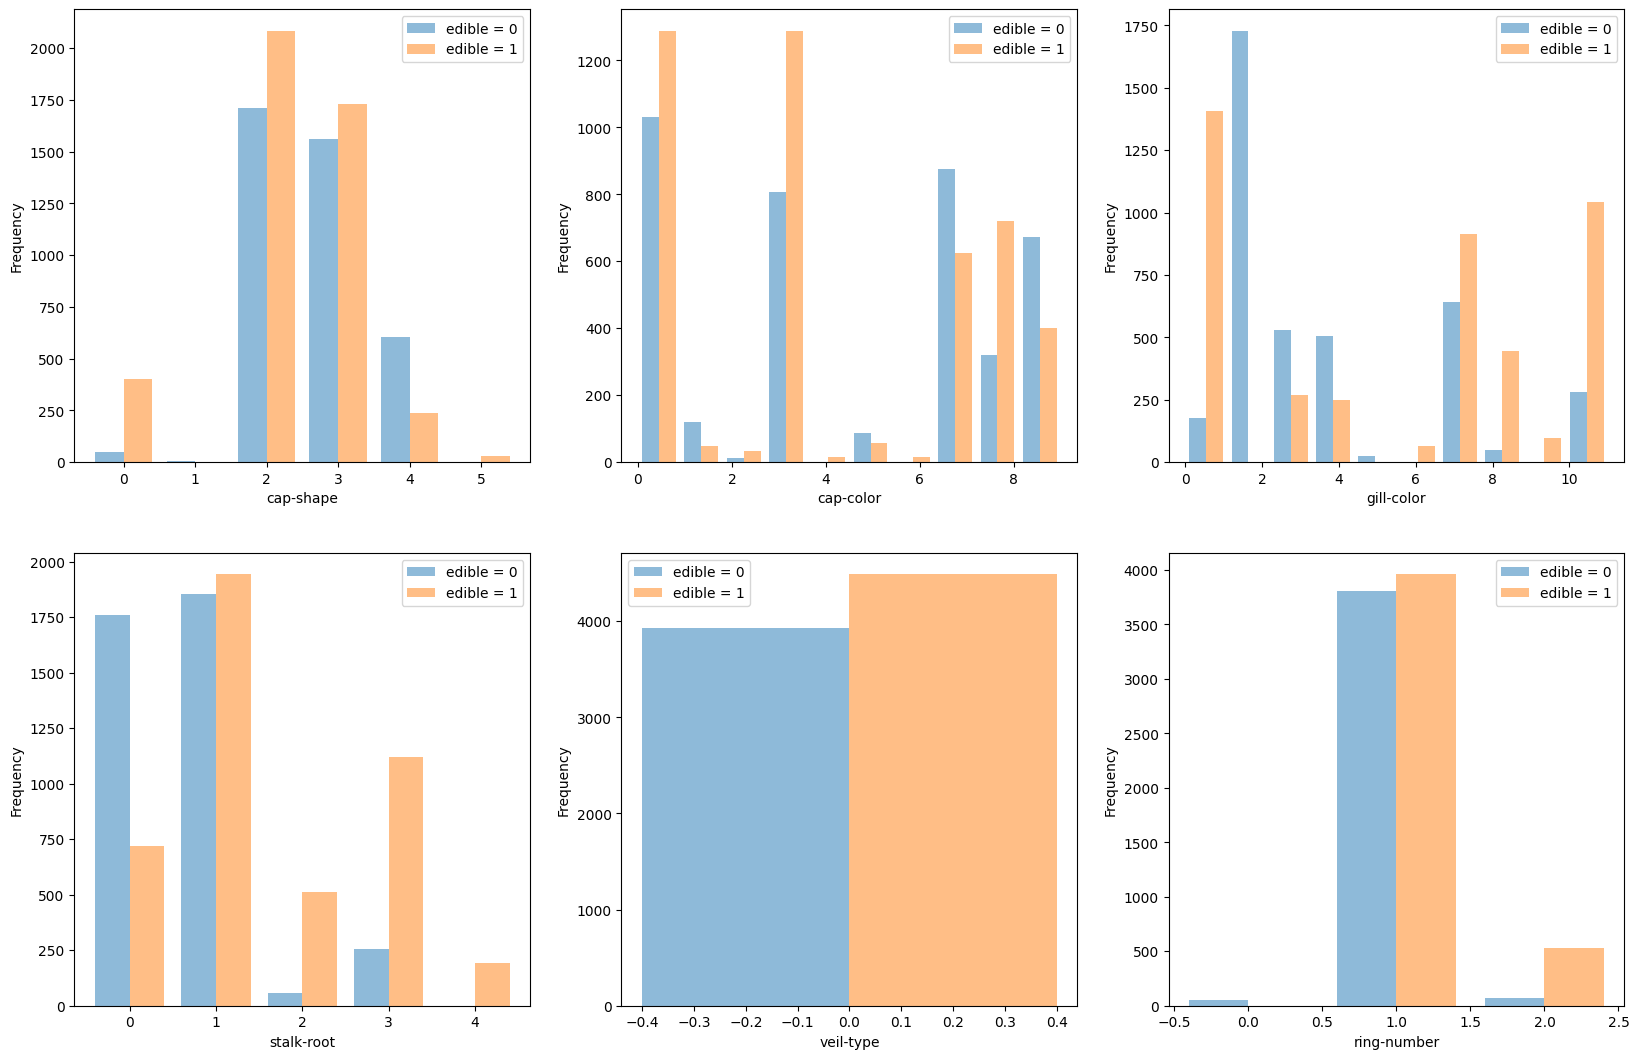

In [9]:
plt.figure()
# Plot histograms of each feature
print('Plotting...')
plot_histograms (X, y, Xnames=Xnames, yname=yname)

In [10]:
# train Majority Vote classifier on data
print('Classifying using Majority Vote...')
clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

Classifying using Majority Vote...
	-- training error: 0.467


In [11]:
print('Classifying using Random Classifier...')

clf2 = RandomClassifier()
clf2.fit(X, y)
y_pred_2 = clf2.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred_2, normalize=True)
print('\t-- training error: %.3f' % train_error)

Classifying using Random Classifier...
	-- training error: 0.498


In [12]:
# evaluate training error of Decision Tree classifier
print('Classifying using DecisionTreeClassifier...')

clf3 = DecisionTreeClassifier(criterion="entropy")
clf3.fit(X, y)
y_pred_3 = clf3.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred_3, normalize=True)
print('\t-- training error: %.3f' % train_error)

Classifying using DecisionTreeClassifier...
	-- training error: 0.055


In [13]:
# evaluate training error of k-Nearest Neighbors classifier
# use k = 3, 11, 19 for n_neighbors
print('Classifying using KNeighborsClassifier...')

clf4 = KNeighborsClassifier(n_neighbors=3)
clf4.fit(X, y)
y_pred_4 = clf4.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred_4, normalize=True)
print('\t-- k=3 training error: %.3f' % train_error)

clf5 = KNeighborsClassifier(n_neighbors=11)
clf5.fit(X, y)
y_pred_5 = clf5.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred_5, normalize=True)
print('\t-- k=11 training error: %.3f' % train_error)

clf6 = KNeighborsClassifier(n_neighbors=19)
clf6.fit(X, y)
y_pred_6 = clf6.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred_4, normalize=True)
print('\t-- k=19 training error: %.3f' % train_error)

print("If we implement the KNN model from scratch, we would use the math.dist() function to find the distances of nearby points")

Classifying using KNeighborsClassifier...
	-- k=3 training error: 0.059
	-- k=11 training error: 0.070
	-- k=19 training error: 0.059
If we implement the KNN model from scratch, we would use the math.dist() function to find the distances of nearby points


In [15]:
# use cross-validation to compute average training and test error of classifiers
print('Investigating various classifiers...')

train_error, test_error, f1_score = error(MajorityVoteClassifier(), X, y, ntrials=100, test_size=0.15)
print('\t-- Majority Vote Classifier training error: %.3f' % train_error)
print('\t-- Majority Vote Classifier testing error: %.3f' % test_error)
print('\t-- Majority Vote Classifier f1 score: %.3f' % f1_score)

train_error, test_error, f1_score = error(RandomClassifier(), X, y, ntrials=100, test_size=0.15)
print('\t-- Random Classifier training error: %.3f' % train_error)
print('\t-- Random Classifier testing error: %.3f' % test_error)
print('\t-- Random Classifier f1 score: %.3f' % f1_score)

train_error, test_error, f1_score = error(DecisionTreeClassifier(criterion="entropy"), X, y, ntrials=100, test_size=0.15)
print('\t-- Decision Tree Classifier training error: %.3f' % train_error)
print('\t-- Decision Tree Classifier testing error: %.3f' % test_error)
print('\t-- Decision Tree Classifier f1 score: %.3f' % f1_score)

train_error, test_error, f1_score = error(KNeighborsClassifier(n_neighbors=11), X, y, ntrials=100, test_size=0.15)
print('\t-- 11-Neighbor Classifier training error: %.3f' % train_error)
print('\t-- 11-Neighbor Classifier testing error: %.3f' % test_error)
print('\t-- 11-Neighbor Classifier f1 score: %.3f' % f1_score)

Investigating various classifiers...
	-- Majority Vote Classifier training error: 0.467
	-- Majority Vote Classifier testing error: 0.467
	-- Majority Vote Classifier f1 score: 0.533
	-- Random Classifier training error: 0.499
	-- Random Classifier testing error: 0.499
	-- Random Classifier f1 score: 0.501
	-- Decision Tree Classifier training error: 0.055
	-- Decision Tree Classifier testing error: 0.055
	-- Decision Tree Classifier f1 score: 0.945
	-- 11-Neighbor Classifier training error: 0.067
	-- 11-Neighbor Classifier testing error: 0.071
	-- 11-Neighbor Classifier f1 score: 0.929


Finding the best k...


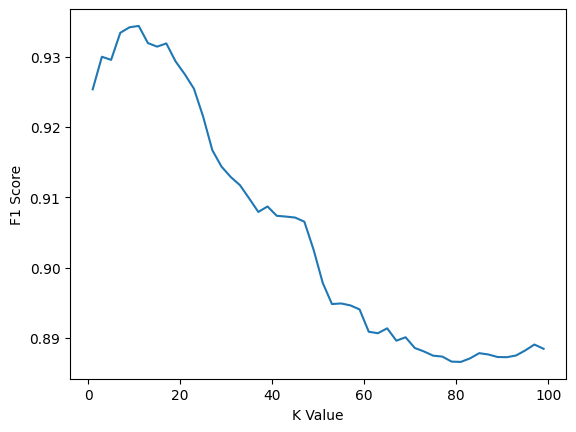

The best value of k is 5 and its F1 value is: 0.934355599302396


In [19]:
print('Finding the best k...')

nums = list(range(0,50))
odd_num = [num * 2 + 1 for num in nums]
f1_scores = []

for k in odd_num:
    f1_score = cross_val_score(KNeighborsClassifier(n_neighbors=k), X, y, scoring="f1", cv=5)
    f1_scores.append(sum(f1_score) / len(f1_score))

plt.plot(odd_num, f1_scores)
plt.xlabel("K Value")
plt.ylabel("F1 Score")
plt.show()

max_value = max(f1_scores)
max_k = ([index for index, item in enumerate(f1_scores) if item == max_value])
print("The best value of k is", max_k[0], "and its F1 value is:", max_value)

Investigating depths...


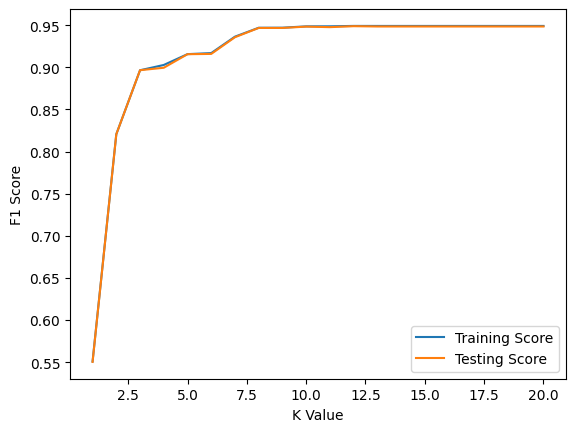

The best training value of k is [11] and its value is: 0.9490925158720813
The best testing value of k is [11] and its value is: 0.9487810317258412
There does not seem to be any overfitting because the training scores are very similar to the testing scores


In [17]:
# investigate decision tree classifier with various depths
print('Investigating depths...')

depths = list(range(1,21))
f1_score_train = []
f1_score_test = []

for k in depths:
    f1_score = cross_validate(DecisionTreeClassifier(criterion="entropy", max_depth=k), X, y, scoring="f1", cv=20, return_train_score=True)
    f1_score_train.append(sum(f1_score['train_score']) / len(f1_score['train_score']))
    f1_score_test.append(sum(f1_score['test_score']) / len(f1_score['test_score']))

# Plots
plt.plot(depths, f1_score_train)
plt.plot(depths, f1_score_test)
plt.xlabel("K Value")
plt.ylabel("F1 Score")
plt.legend(["Training Score", "Testing Score"])
plt.show()

# Find optimal values
max_value = max(f1_score_train)
max_k = ([index for index, item in enumerate(f1_score_train) if item == max_value])
print("The best training value of k is", max_k, "and its value is:", max_value)

max_value = max(f1_score_test)
max_k = ([index for index, item in enumerate(f1_score_test) if item == max_value])
print("The best testing value of k is", max_k, "and its value is:", max_value)
print("There does not seem to be any overfitting because the training scores are very similar to the testing scores")